In [1]:
import re
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from umap import UMAP


sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})

c:\tools\miniconda3\envs\py310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\tools\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data from the database

In [2]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        ROUND((g.result + 1)) as result,
        g.url,
        p.eval,
        p.fen,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0.1
        AND p.eval is not NULL
    GROUP BY
        p.fen
    """

query2 = """
    SELECT 
        g.result,
        g.elo_white - g.elo_black as elo_dif
    FROM games g
    WHERE g.result != 0
    """

query3 = """
    SELECT 
        p.eval,
        COUNT(g.url)
    FROM positions p JOIN games g
    ON g.rowid = p.game_id
    GROUP BY g.url
    """

with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()


### Weight moves by number of moves in each game

In [3]:
g = data.groupby("url").count()
data2 = data.merge(g.result, on="url", suffixes=("", "_y"))
data2.weight = data2.weight / data2.result_y


### Define the steps in the analysis pipeline

In [4]:
random_state = 42

features = [
    "eval",
    # "ply",
    # "elo_dif",
]

X = data2[features]
y = data2.result
weights = data2.weight * 55_000 / 700

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=random_state, 
    # stratify=y
)

scaler = StandardScaler()

embedder = UMAP(
    min_dist=0,
    n_components=3,
    n_neighbors=15,
    # densmap=True,
    metric="correlation",
    unique=True
    # target_metric="euclidean"
)

classifier = LogisticRegressionCV(
    Cs=20,
    # Cs=[1],
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=10),
    # fit_intercept=False,
    # class_weight="balanced",
)

model = Pipeline(
    steps=[
        ("scaler", scaler),
        # ("embedding", embedder),
        ("classifier", classifier),
    ],
    verbose=True
)

model.fit(
    X_train,
    y_train,
    scaler__sample_weight=weights_train,
    classifier__sample_weight=weights_train,
)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   5.3s


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegressionCV(Cs=20,
                                      l1_ratios=array([0.0, 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667, 0.77778,
       0.88889, 1.0]),
                                      n_jobs=-1, penalty='elasticnet',
                                      random_state=42, solver='saga'))],
         verbose=True)

### Show resulting coefficients

In [5]:
print(f"Accuracy: \n {model.score(X_test, y_test, sample_weight=weights_test)}")
scale = model.named_steps["scaler"].scale_
mean = model.named_steps["scaler"].mean_
print(f"Mean: \n {mean}")

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_
print(f"L1 Ratio: {l1_ratio}")


Accuracy: 
 0.6304675491584707
Mean: 
 [82.506]
Coefficients: 
 [[-0.00069229]
 [0.0]
 [0.0015999]]
Intercept: 
 [0.37612 -0.92187 0.54575]
Regularization strenght: 
 [0.012743 0.012743 0.012743]
L1 Ratio: [0.77778 0.77778 0.77778]


### Show results

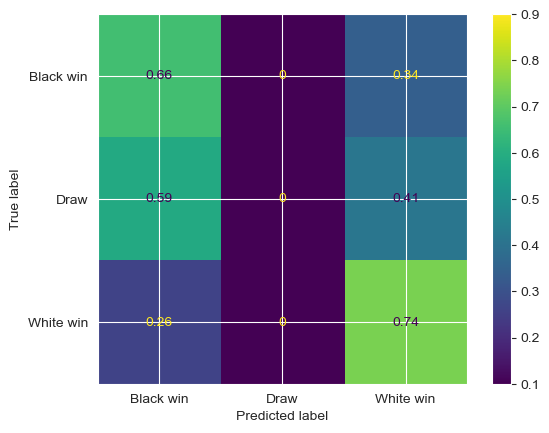

In [6]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    sample_weight=weights_test,
    normalize="true",
    display_labels=[
        "Black win",
        "Draw",
        "White win",
    ],
    im_kw={"vmin":0.1,
    "vmax":0.9}
)

plt.savefig("images\\tmp\\confusion_matrix_with_elo.png", dpi=300, facecolor="white")


### Plots

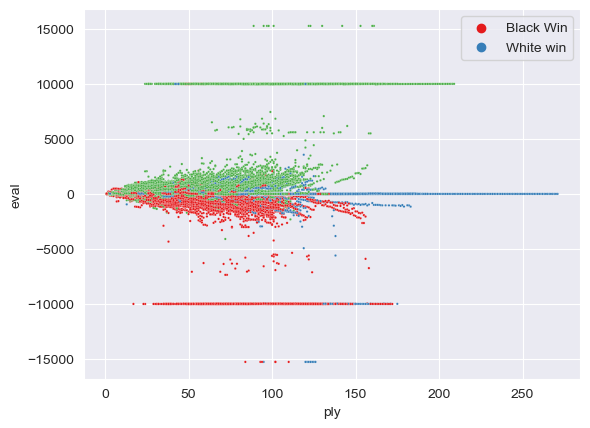

In [7]:
pd.set_option("mode.chained_assignment", None)

data_plot = data[["eval", "ply", "elo_dif", "result"]]
data_plot.loc[:, "result"] = (data_plot.loc[:, "result"] + 1).copy() / 2

g = sns.scatterplot(
    data_plot,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)

legend = ["Black Win", "White win"]
handles, labels = g.get_legend_handles_labels()
g.legend(handles, legend)

plt.savefig("images\\tmp\\ply_eval.png", dpi=300, facecolor="white")


<AxesSubplot: xlabel='eval', ylabel='Chance'>

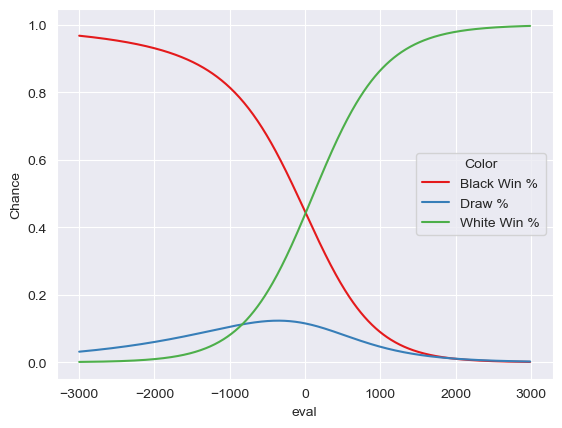

In [8]:
cps = pd.DataFrame(np.arange(-3000, 3000, 10), columns=["eval"])
pred = pd.DataFrame(
    model.predict_proba(cps), columns=["Black Win %", "Draw %", "White Win %"]
)
data_plot = pd.concat([cps, pred], axis=1)

df_melted = data_plot.melt("eval", var_name="Color", value_name="Chance")

sns.lineplot(data=df_melted, x="eval", y="Chance", hue="Color", palette="Set1")
# plt.savefig("images\\tmp\\eval_winchance.png", dpi=300, facecolor="white")


In [9]:
def p(X, exponent, intercept):
    p = 1 / (1 + np.exp(-X * exponent - intercept))
    return p
